In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
# from sklearn.svm import SVC

# DataFrame Sampling : BoRace

In [5]:
# df = pd.read_csv('../Data/Cleaned_data.csv')
df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
print(df['BoRace'].value_counts())

df = df[df['BoRace'] != 4]
min_count = df['BoRace'].value_counts().min()
df = df.groupby('BoRace').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
print(df['BoRace'].value_counts())

BoRace
5    604701
7     27157
2     17991
6     15949
3     10331
1      3772
4       966
Name: count, dtype: int64
BoRace
1    3772
2    3772
3    3772
5    3772
6    3772
7    3772
Name: count, dtype: int64


# train_test_split


Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.1626, Precision: 0.8604, Recall: 0.1667, F1-Score: 0.0466, Specificity: 0.8333
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.6055, Precision: 0.6203, Recall: 0.6060, F1-Score: 0.6083, Specificity: 0.9212
Time taken: 3.42 seconds

Model: Decision Tree
 Accuracy: 0.4939, Precision: 0.4929, Recall: 0.4937, F1-Score: 0.4933, Specificity: 0.8988
Time taken: 0.25 seconds

Model: Extra Trees
 Accuracy: 0.5863, Precision: 0.5985, Recall: 0.5867, F1-Score: 0.5885, Specificity: 0.9173
Time taken: 1.75 seconds

Model: Gradient Boosting
 Accuracy: 0.6119, Precision: 0.6320, Recall: 0.6123, F1-Score: 0.6155, Specificity: 0.9224
Time taken: 27.99 seconds



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: Logistic Regression
 Accuracy: 0.2691, Precision: 0.2516, Recall: 0.2677, F1-Score: 0.2447, Specificity: 0.8537
Time taken: 2.33 seconds

Model: XGBoost
 Accuracy: 0.6163, Precision: 0.6269, Recall: 0.6165, F1-Score: 0.6192, Specificity: 0.9233
Time taken: 0.59 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 18105, number of used features: 28
[LightGBM] [Info] Start training from score -1.792920
[LightGBM] [Info] Start training from score -1.799578
[LightGBM] [Info] Start training from score -1.787626
[LightGBM] [Info] Start training from score -1.787626
[LightGBM] [Info] Start training from score -1.785647
[LightGBM] [Info] Start training from score -1.797243
Model: LightGBM
 Accuracy: 0.

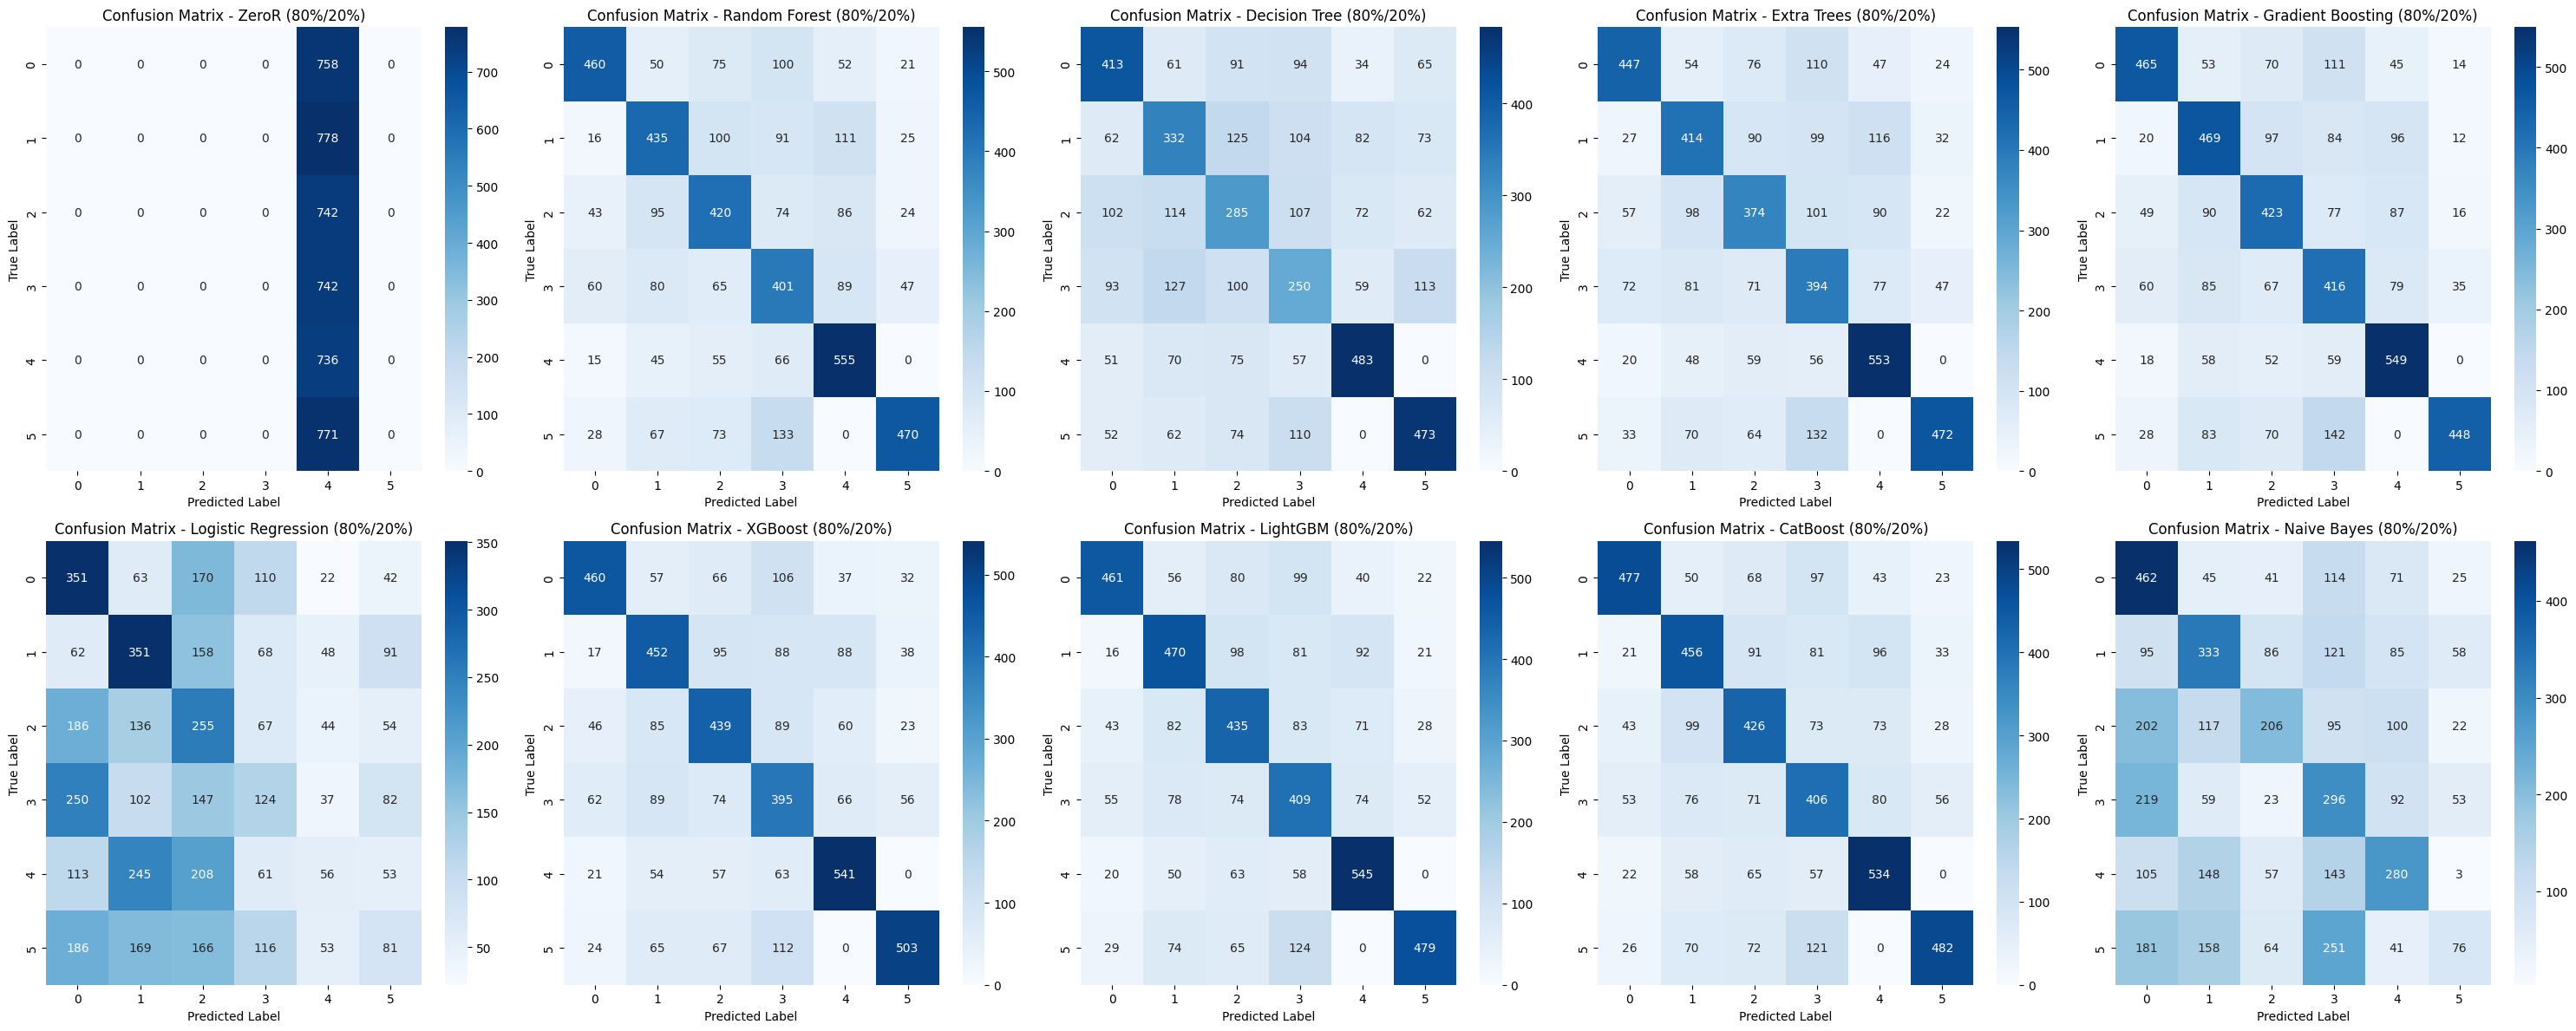

In [6]:
results_dir = "BoRace_SPLITS"
os.makedirs(results_dir, exist_ok=True)

X = df.drop(columns=["BoRace", "CoRace"])
y = df["BoRace"]

# splits = [(0.90, 0.10), (0.80, 0.20), (0.70, 0.30)]
train_size = 0.80
test_size = 0.20

models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    # "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), 
    # "KNN": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Naive Bayes": GaussianNB(),
    # models["SVM"] = SVC(probability=True, random_state=42)
}


def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

train_percent = int(train_size * 100)
test_percent = int(test_size * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(f"\nTraining/Testing Split: {train_percent}%/{test_percent}%\n")

results = {}
conf_matrices = {}
for name, model in models.items():
    start_time = time.time()
    
    if name == "XGBoost":
        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)
        model.fit(X_train, y_train_enc)
        y_pred = le.inverse_transform(model.predict(X_test))

    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=1)
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    spec = specificity_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    elapsed_time = time.time() - start_time
    
    results[name] = {
        "Accuracy": acc, 
        "Precision": prec, 
        "Recall": rec, 
        "F1-Score": f1, 
        "Specificity": spec,
        "Total Runtime (s)": elapsed_time,
    }
    conf_matrices[name] = cm
    print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
    print("Time taken: {:.2f} seconds\n".format(elapsed_time))
    
results_df = pd.DataFrame(results).T
results_file = f"{results_dir}/results_split_{train_percent}_{test_percent}.csv"
results_df.to_csv(results_file, index=True)
print(f"Results saved to {results_file}")

for name, cm in conf_matrices.items():
    cm_file = f"{results_dir}/conf_matrix_{train_percent}_{test_percent}_{name.replace(' ', '_')}.csv"
    pd.DataFrame(cm).to_csv(cm_file, index=False)
    print(f"Confusion Matrix for {name} saved to {cm_file}")

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Normalized Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    save_path = os.path.join(results_dir, f"conf_matrix_{name.replace(' ', '_')}.png")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

plt.tight_layout()
plt.show()

# cross_val_predict


Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.1666, Precision: 0.7222, Recall: 0.1666, F1-Score: 0.0762, Specificity: 0.8333
Time taken: 0.03 seconds
Time taken: 0.00 minutes

Model: Random Forest
 Accuracy: 0.5817, Precision: 0.6021, Recall: 0.5817, F1-Score: 0.5841, Specificity: 0.9163
Time taken: 39.33 seconds
Time taken: 0.66 minutes

Model: Decision Tree
 Accuracy: 0.4690, Precision: 0.4697, Recall: 0.4690, F1-Score: 0.4688, Specificity: 0.8938
Time taken: 3.74 seconds
Time taken: 0.06 minutes

Model: Extra Trees
 Accuracy: 0.5440, Precision: 0.5561, Recall: 0.5440, F1-Score: 0.5433, Specificity: 0.9088
Time taken: 23.33 seconds
Time taken: 0.39 minutes

Model: Gradient Boosting
 Accuracy: 0.5884, Precision: 0.6135, Recall: 0.5884, F1-Score: 0.5924, Specificity: 0.9177
Time taken: 343.83 seconds
Time taken: 5.73 minutes



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Model: Logistic Regression
 Accuracy: 0.2465, Precision: 0.2348, Recall: 0.2465, F1-Score: 0.2271, Specificity: 0.8493
Time taken: 23.72 seconds
Time taken: 0.40 minutes



c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Model: XGBoost
 Accuracy: 0.5736, Precision: 0.5868, Recall: 0.5736, F1-Score: 0.5721, Specificity: 0.9147
Time taken: 6.37 seconds
Time taken: 0.11 minutes

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3292
[LightGBM] [Info] Number of data points in the train set: 20368, number of used features: 28
[LightGBM] [Info] Start training from score -1.791956
[LightGBM] [Info] Start training from score -1.791661
[LightGBM] [Info] Start training from score -1.791661
[LightGBM] [Info] Start training from score -1.791661
[LightGBM] [Info] Start training from score -1.791661
[LightGBM] [Info] Start training from score -1.791956
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

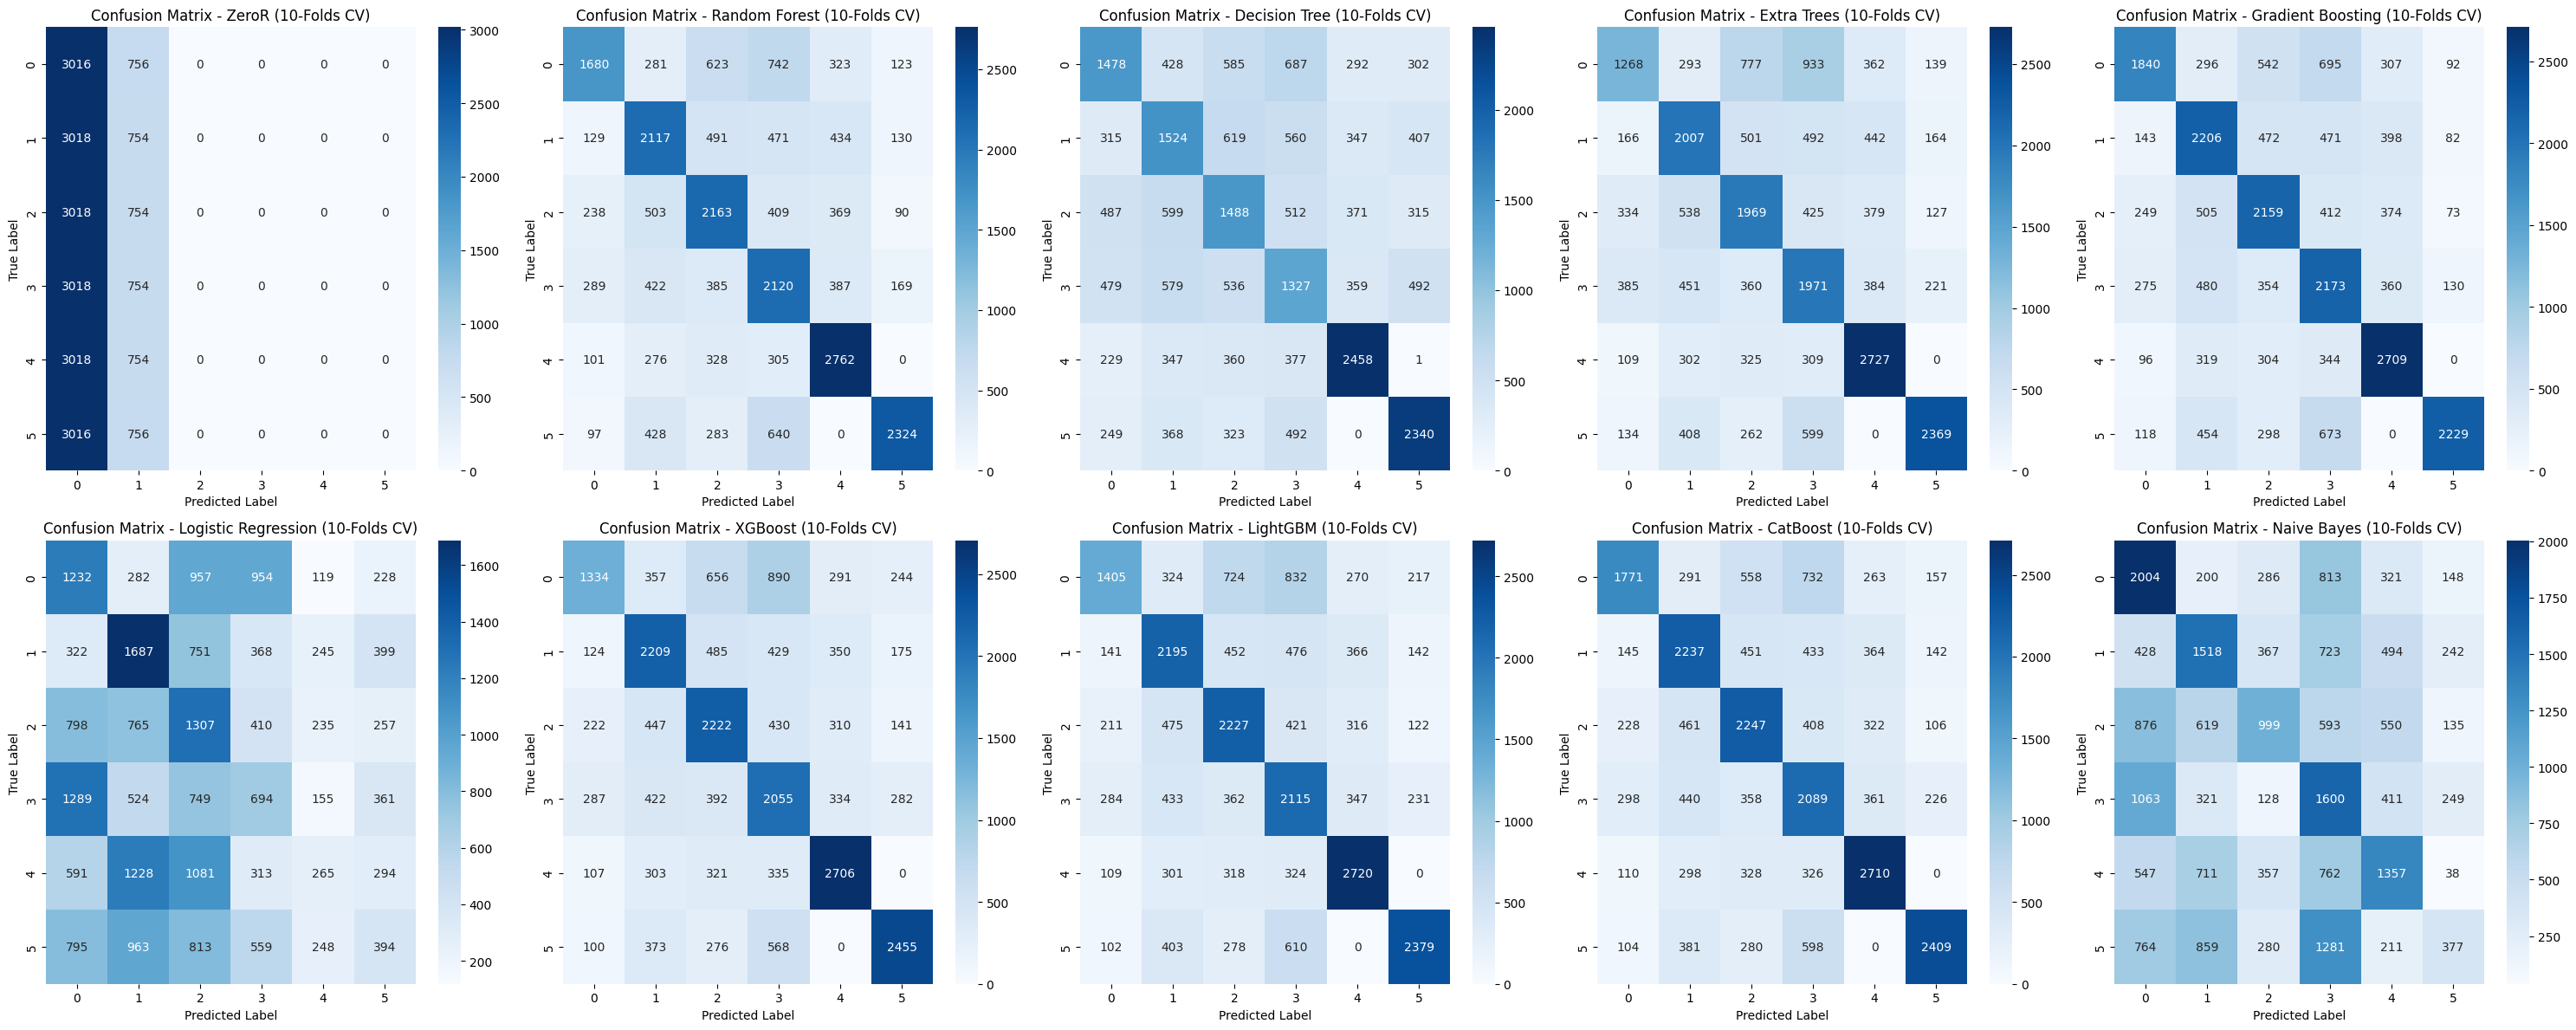

In [ ]:
cv_results_dir = "BoRace_CV"
os.makedirs(cv_results_dir, exist_ok=True)

X = df.drop(columns=["BoRace", "CoRace"])
y = df["BoRace"]

# folds_list = [5]
num_folds = 10

models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    # "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), 
    # "KNN": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Naive Bayes": GaussianNB(),
    # models["SVM"] = SVC(probability=True, random_state=42)
}

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

def cross_val_predict_xgb(model, X, y, cv):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_pred_all = np.zeros_like(y_encoded)

    for train_idx, test_idx in cv.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model.fit(X_train, y_train)
        y_pred_fold = model.predict(X_test)
        y_pred_all[test_idx] = y_pred_fold

    y_pred_final = le.inverse_transform(y_pred_all)
    return y_pred_final

# for num_folds in folds_list:
print(f"\nPerforming {num_folds}-fold cross-validation\n")
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

results = {}
conf_matrices = {}

for name, model in models.items():
    start_time = time.time()

    if name == "XGBoost":
        y_pred = cross_val_predict_xgb(model, X, y, cv=kf)
    else:
        y_pred = cross_val_predict(model, X, y, cv=kf)

    total_runtime = time.time() - start_time
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=1)
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    spec = specificity_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
    results[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1,
        "Specificity": spec, "Total Runtime (s)": total_runtime, "Total Runtime (min)": total_runtime / 60
    }
    
    conf_matrices[name] = cm
    
    print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
    print("Time taken: {:.2f} seconds".format(total_runtime))
    print("Time taken: {:.2f} minutes\n".format(total_runtime / 60))

results_df = pd.DataFrame(results).T
results_file = f"{cv_results_dir}/results_cv_{num_folds}_folds.csv"
results_df.to_csv(results_file, index=True)
print(f"Results saved to {results_file}")

for name, cm in conf_matrices.items():
    cm_file = f"{cv_results_dir}/conf_matrix_cv_{num_folds}_folds_{name.replace(' ', '_')}.csv"
    pd.DataFrame(cm).to_csv(cm_file, index=False)
    print(f"Confusion Matrix for {name} saved to {cm_file}")

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name} ({num_folds}-Folds CV)')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Normalized Confusion Matrix - {name} ({num_folds}-Folds CV)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    save_path = os.path.join(cv_results_dir, f"conf_matrix_{name.replace(' ', '_')}.png")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

plt.tight_layout()
plt.show()

# Feature Selection

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def run_rfecv(model, df, target_col='BoRace', scoring='accuracy', results_dir="BoRace_RFECV"):
    model_name = type(model).__name__
    
    X = df.drop(columns=[target_col, "CoRace"])
    y = df[target_col]

    selector = RFECV(
        estimator=model,
        step=1,
        cv=StratifiedKFold(5),
        scoring=scoring,
        n_jobs=-1
    )

    selector.fit(X, y)

    selected_features = X.columns[selector.support_]
    try:
        importances = selector.estimator_.feature_importances_
    except AttributeError:
        try:
            importances = np.abs(selector.estimator_.coef_).flatten()
        except AttributeError:
            importances = np.zeros(len(selected_features))

    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    importance_csv_path = os.path.join(results_dir, f"{model_name}_rfecv_importances.csv")
    importance_df.to_csv(importance_csv_path, index=False)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1),
             selector.cv_results_['mean_test_score'], marker='o')
    plt.xlabel("Number of Selected Features")
    plt.ylabel(f"CV Score ({scoring})")
    plt.title(f"RFECV - {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(results_dir, f"{model_name}_rfecv_plot.png")
    plt.savefig(plot_path)
    plt.close()
    
    print(f"{model_name}: Best {selector.n_features_} features selected. Results saved to {importance_csv_path}")

results_dir = "BoRace_RFECV"
os.makedirs(results_dir, exist_ok=True)

X = df.drop(columns=["BoRace", "CoRace"])
y = df["BoRace"]


models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    ExtraTreesClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42), 
    LGBMClassifier(random_state=42),
    CatBoostClassifier(verbose=0, random_state=42),
]

for model in models:
    run_rfecv(model, df=df)

RandomForestClassifier: Best 27 features selected. Results saved to BoRace_RFECV\RandomForestClassifier_rfecv_importances.csv
ExtraTreesClassifier: Best 22 features selected. Results saved to BoRace_RFECV\ExtraTreesClassifier_rfecv_importances.csv
GradientBoostingClassifier: Best 27 features selected. Results saved to BoRace_RFECV\GradientBoostingClassifier_rfecv_importances.csv
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 28
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Ligh

# Fairness Analysis : LightGBM

In [11]:
import pandas as pd

model_scroes = pd.read_csv('BoRace_CV/results_cv_5_folds.csv')
model_scroes[['Unnamed: 0', 'Accuracy','Total Runtime (s)']].sort_values(by='Accuracy', ascending=False).head()

,Unnamed: 0,Accuracy,Total Runtime (s)
8,CatBoost,0.558413,25.442761
4,Gradient Boosting,0.553066,174.599670
7,LightGBM,0.535127,12.150838
1,Random Forest,0.534597,15.915172
6,XGBoost,0.530002,28.128011


c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\preprocessing\_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Matin\Documents\CIS890\myenv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class 

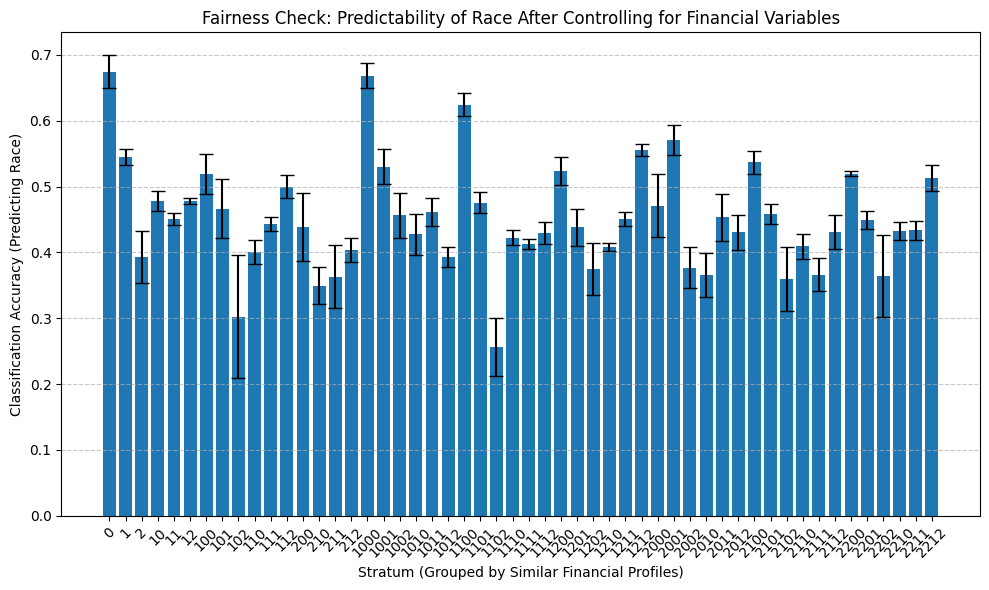

In [12]:
control_vars = ['Income_adjusted', 'Borrower Credit Score', 'Front', 'Back']
target = 'BoRace'

df_clean = df.dropna(subset=control_vars + [target])

# Stratify using KBinsDiscretizer (quantile binning)
binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
binned_controls = binning.fit_transform(df_clean[control_vars])
strata_labels = pd.Series(np.sum(binned_controls * (10 ** np.arange(binned_controls.shape[1])), axis=1), name="Stratum")

df_clean['Stratum'] = strata_labels
results = []

for stratum, group in df_clean.groupby('Stratum'):
    if group[target].nunique() < 2 or len(group) < 30:
        continue  # Skip strata that lack enough diversity or samples

    X = group.drop(columns=[target, 'Stratum'])
    y = group[target]

    # Drop protected attributes from predictors
    X = X.drop(columns=['BoGender', 'CoGender', 'CoRace'], errors='ignore')

    model = CatBoostClassifier(verbose=0, random_state=42)
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')

    results.append({
        'Stratum': str(int(stratum)),  # For readable x-axis
        'Samples': len(group),
        'Mean Accuracy': np.mean(scores),
        'Std Error': np.std(scores, ddof=1) / np.sqrt(len(scores)),
        'Std Dev': np.std(scores),
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# === Plot the results ===
plt.figure(figsize=(10, 6))
plt.bar(results_df['Stratum'], results_df['Mean Accuracy'], yerr=results_df['Std Error'], capsize=5)
plt.xlabel("Stratum (Grouped by Similar Financial Profiles)")
plt.ylabel("Classification Accuracy (Predicting Race)")
plt.title("Fairness Check: Predictability of Race After Controlling for Financial Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Bin 0 ≈ low (0–33%)

Bin 1 ≈ medium (33–66%)

Bin 2 ≈ high (66–100%)

In [14]:
results_df['Stratum'] = results_df['Stratum'].astype(int)
bin_df = pd.DataFrame(binned_controls, columns=[f"{var}_bin" for var in control_vars])
df_strata = pd.concat([df_clean.reset_index(drop=True), bin_df], axis=1)
df_strata["Stratum"] = np.sum(binned_controls * (10 ** np.arange(binned_controls.shape[1])), axis=1)
decoded = df_strata.groupby("Stratum")[[f"{var}_bin" for var in control_vars]].first().reset_index()
results_with_bins = results_df.merge(
    df_strata.groupby("Stratum")[[f"{var}_bin" for var in control_vars]].first().reset_index(),
    on="Stratum", how="left"
)
results_with_bins.to_csv('BoRace_Fairness.csv', index=False)
results_with_bins

,Stratum,Samples,Mean Accuracy,Std Error,Std Dev,Income_adjusted_bin,Borrower Credit Score_bin,Front_bin,Back_bin
0,0,218,0.674419,0.025026,0.050053,0.0,0.0,0.0,0.0
1,1,200,0.545000,0.012247,0.024495,1.0,0.0,0.0,0.0
2,2,181,0.392793,0.039662,0.079323,2.0,0.0,0.0,0.0
3,10,492,0.477633,0.015015,0.030031,0.0,1.0,0.0,0.0
4,11,1177,0.450317,0.009056,0.018112,1.0,1.0,0.0,0.0
5,12,2289,0.478368,0.004950,0.009899,2.0,1.0,0.0,0.0
6,100,179,0.519365,0.030324,0.060648,0.0,0.0,1.0,0.0
7,101,90,0.466667,0.045134,0.090267,1.0,0.0,1.0,0.0
8,102,49,0.302222,0.093716,0.187432,2.0,0.0,1.0,0.0
9,110,626,0.400940,0.017839,0.035679,0.0,1.0,1.0,0.0
